# LLM providers

There is a variety of LLM providers out there. OpenAI, which most of the folks have heard already, Google's Gemini,
Antrophic's Claude, and more. And that's mentioning only 3rd party providers. There are also open-source/weight models that
one can access (e.g. from Hugging Face) and self-host. 
Each of them has different pros and cons that should be considered when choosing the right one actual project. During this workshop, we will utilize LLM via API provider – OpenAI API. 

**Advantages and disadvantages of utilizing 3rd party provider:**

**Pros**

1. **Easy to use:** The API's are often simple, well-documented, making them overally easy to integrate.
2. **Scalable:** We're using API, which simplifies our application deployment and scaling (we don't maintain any services running, just call as we go) – and pay as we go. Self-hosting might be often necessary and more cost-effective – but requires maintenance and expertise to do it right.
3. **Performance:** As generic LLM, 3rd party providers often can offer better performance than OSS models – the latter are still falling a little behind.
4. **Continuous Improvement:** Vendors continually updates and improves its models, so your applications can benefit from cutting-edge advancements in AI without needing significant internal resources working on the models themselves.


**Cons**
1. **Cost:** Using the API extensively can be expensive. With self-hosted models, especially if done and optimized properly, you can achieve better hardware costs (but at a tradeoff of needing the necessary expertise and development/maintenance people cost)  but this You'll be charged based on the number of tokens processed.
2. **Limited customization options:** You can't control how models are trained. 3rd party providers often provide some finetuning capabilities – but they're limited.
3. **Data Privacy Concerns:** Using a third-party API may raise concerns about data privacy and security, particularly in industries that handle sensitive information or/and are regulated (healthcare, fintech, etc.).
4. **Dependence on a third party service:** Relying on an external API means you're dependent on its uptime, updates, and potential changes in pricing or terms of service. While models performance usually improves in time, it may also change in a way that might not be beneficial for your application.

## Setting up the API access

As mentioned, during the workshop we will mainly rely on 3rd party provider, for the sake of convenience. We will use OpenAI API, which is one of the most popular and well-known providers.
<br><br>
In order to utilize that, you need to have an API key that you will use to authenticate your requests. Before the workshop, you should have received a key via email from the organizers.
<br><br>
You can get also get and use your API key by signing up on OpenAI's platform [here](https://platform.openai.com/login?launch). After signing up, you will be able to create a new project and API key dedicated to it in relevant sections.
<br><br>
The keys offered by organizers are limited in terms of their total budget – but overall, unless someone goes wild with some of the exercises, it shouldn't take more than 1-2$ (likely less) to run the whole workshop.

In the repostiory, there is a reference **.env** file callled **.env.template** – copy it in place, rename it to **.env** and fill your API key inside. Then, we will set it in our notebook environment context and get into variable.

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv(".env")
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

## Hello world – first call to OpenAI API

In [ ]:
from openai import OpenAI

client = OpenAI(api_key=OPENAI_API_KEY)
model = "gpt-4o-mini"

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You're a helpful tutor, answering questions asked to you in an informative and easy to understand way.",
        },
        {
            "role": "user",
            "content": "What is AI?",
        }
    ],
    max_tokens=1000,
    model=model,
)

print(chat_completion.choices[0].message.content)

Great, we've got our first message returned – just like in chat UI's.

**Exercise:** While we've got the text content and this is something we by default see as the users, there is more than that. Familiarize yourself with the response format and see what other interesting properties you may find.

In [ ]:
# TODO

**Exercise**: In the next cell is a function that allows you to check the price of your API call (according to the [OpenAI API pricing docs](https://openai.com/api/pricing/)).
Use it to check how much it cost to make the call. You can use this feature throughout the notebook to do this.

If you want to learn more about OpenAI API - here is the full reference: [link](https://platform.openai.com/docs/overview)

In [ ]:
from decimal import Decimal
from typing import Any


def get_completion_price(chat_completion: Any) -> Decimal:
    # Hardcoded here, ideally would be dynamic – actually there are packages keeping track of that (e.g. https://github.com/AgentOps-AI/tokencost)
    pricing = {
        "gpt-4o-mini-2024-07-18": {"per_1k_input_tokens": Decimal("0.000150"), "per_1k_output_tokens": Decimal("0.000600")},
        "gpt-4o-2024-08-06": {"per_1k_input_tokens": Decimal("0.00250"), "per_1k_output_tokens": Decimal("0.01000")},
    }

    chat_completion = chat_completion.to_dict()

    input_tokens = chat_completion["usage"]["prompt_tokens"]
    price_per_1k_input_tokens = pricing[chat_completion["model"]]["per_1k_input_tokens"]

    output_tokens = chat_completion["usage"]["completion_tokens"]
    price_per_1k_output_tokens = pricing[chat_completion["model"]]["per_1k_output_tokens"]

    total_price = (Decimal(input_tokens) / Decimal(1000)) * price_per_1k_input_tokens + (
        Decimal(output_tokens) / Decimal(1000)
    ) * price_per_1k_output_tokens
    return total_price

# How does it look with different providers?

In general, base functionalities provided by most LLM providers, and their APIs, are fairly similar. Let's take a look at how the call would look like if we were using Anthropic's Claude.

```import os
from anthropic import Anthropic

client = Anthropic(
    api_key=os.environ.get("ANTHROPIC_API_KEY"),
)
model="claude-3-opus-20240229",

message = client.messages.create(
    system="You're a helpful tutor, answering questions asked to you in an informative and easy to understand way.",
    messages=[
        {
            "role": "user",
            "content": "What is AI?",
        }
    ],
    max_tokens=1000,
    model=model,
)
print(message.content)
```

Pretty similar, right? But not entirely. While having similar signatures, there are differences e.g. in how to obtain the final output message, system prompt is passed outside of messages, etc.

So we need to tweaks/adjustments when switching providers...

# But do we need to write those classes on our own? Enter LangChain

There is a number of great libraries helping with development of LLM-based applications, and **LangChain** is (the most popular) one of them. It provides a set of tools and abstractions that make it easier to build complex, multi-step language model-driven applications, enabling developers to chain together multiple operations and interact with various data sources. And, with a huge community (>90k Github stars) it unifies and maintains common interfaces to a number of crucial tools and APIs such as LLM providers, Vector Databases, Agents, and more. Let's take a look at our previous example – adjusted to Langchain.

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

llm = ChatOpenAI(model=model, api_key=OPENAI_API_KEY)
response = llm.invoke([
    SystemMessage("You're a helpful tutor, answering questions asked to you in an informative and easy to understand way."), 
    HumanMessage(content="What is AI?")
], max_tokens=1000)

first_answer = response.content
print(first_answer)

Now, if we were to utilize Claude's API, the only change we would need to handle would be another import, and utilized class replacement:
```
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model=model, api_key=ANTHROPIC_API_KEY)
```
the other code after initialization would stay as it was (the same also applies to other components we haven't touched yet).

But enough about that – let's continue conversation with our model.

In [ ]:
response = llm.invoke([HumanMessage(content="It is really interesting what you have written. Can you say more about it?")])
print(response.content)

**As you can see - the model by itself doesn't remember the history of messages. We need to pass all messages to get the desired answers.**

In [ ]:
from langchain_core.messages import AIMessage

response = llm.invoke(
    [
        SystemMessage("You're a helpful tutor, answering questions asked to you in an informative and easy to understand way."),
        HumanMessage(content="What is AI?"),
        AIMessage(
            content=first_answer,
        ),
        HumanMessage(content="It is really interesting what you have written. Can you say more about it?"),
    ]
)

print(response.content)

# Message History

Which if done manually would be pretty tedious – especially given that there is a number of possible memory implementation approaches, and not all of them are being straightforward. Let's take a shot at memory using our already introduced framework.

In [ ]:
from langchain_core.chat_history import (
    BaseChatMessageHistory,
    InMemoryChatMessageHistory,
)
from langchain_core.runnables.history import RunnableWithMessageHistory

STORE = {}

def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in STORE:
        STORE[session_id] = InMemoryChatMessageHistory()
    return STORE[session_id]


chain_with_history = RunnableWithMessageHistory(llm, get_session_history)

In [ ]:
config = {"configurable": {"session_id": "session_1"}}

response = chain_with_history.invoke(
    [SystemMessage("You're a helpful tutor, answering questions asked to you in an informative and easy to understand way."),
    HumanMessage(content="What is AI?")],
    config=config,
)

print(response.content)

In [ ]:
response = chain_with_history.invoke(
    [HumanMessage(content="It is really interesting what you have written. Can you say more about it?")],
    config=config,
)

print(response.content)

**Exercise:** How we could switch to different conversation now? Let's change it and explore how our chain will behave. Can you explain why?

More on message history with Langchain [here](https://python.langchain.com/v0.2/docs/how_to/message_history/).

**Exercise:** We've been utilizing system prompt for a while. It is a special prompt, that sets up the overall behaviour, tone, and approach of the AI for a specific session or interaction. Change it now at the start of a new sesssion to something crazy – e.g. set up a role to be a pirate, or medieval knight that should speak as such. Does it indeed affect the whole conversation? Does system message have effect across all sessions?

## Different types of Memory

As mentioned, there are different types of possible Memory implementation. Some of the popular ones include:

- all messages (presented earlier)
- trim messages
    - (+) helps to reduce context
    - (-) older parts of conversation will be discarded and not passed to LLM
- summarize conversation
    - (+) helps to reduce context
    - (-) some parts of conversation during summarization might be lost, but will better preserve older parts of conversation than trimming

**Exercise:** Pick one of the described memories, and modify our current global STORE to use the selected approach
(for Trim memory, use some low value to observe the changes faster). Can you observe the described pros and cons?

Hint: here is a documentation with examples for both, that could be really helpful: https://python.langchain.com/v0.2/docs/how_to/chatbots_memory/#trimming-messages

# RAG

We have a connection to an LLM. We also gave it memory. It's pretty nice to have the ability to chat, and it being consistent throughout the conversation / referring to previous messages and facts from it. But just chatting with LLM that way is still pretty limited. We can ask it about general knowledge. But nowadays, modern systems look more as in the picture:

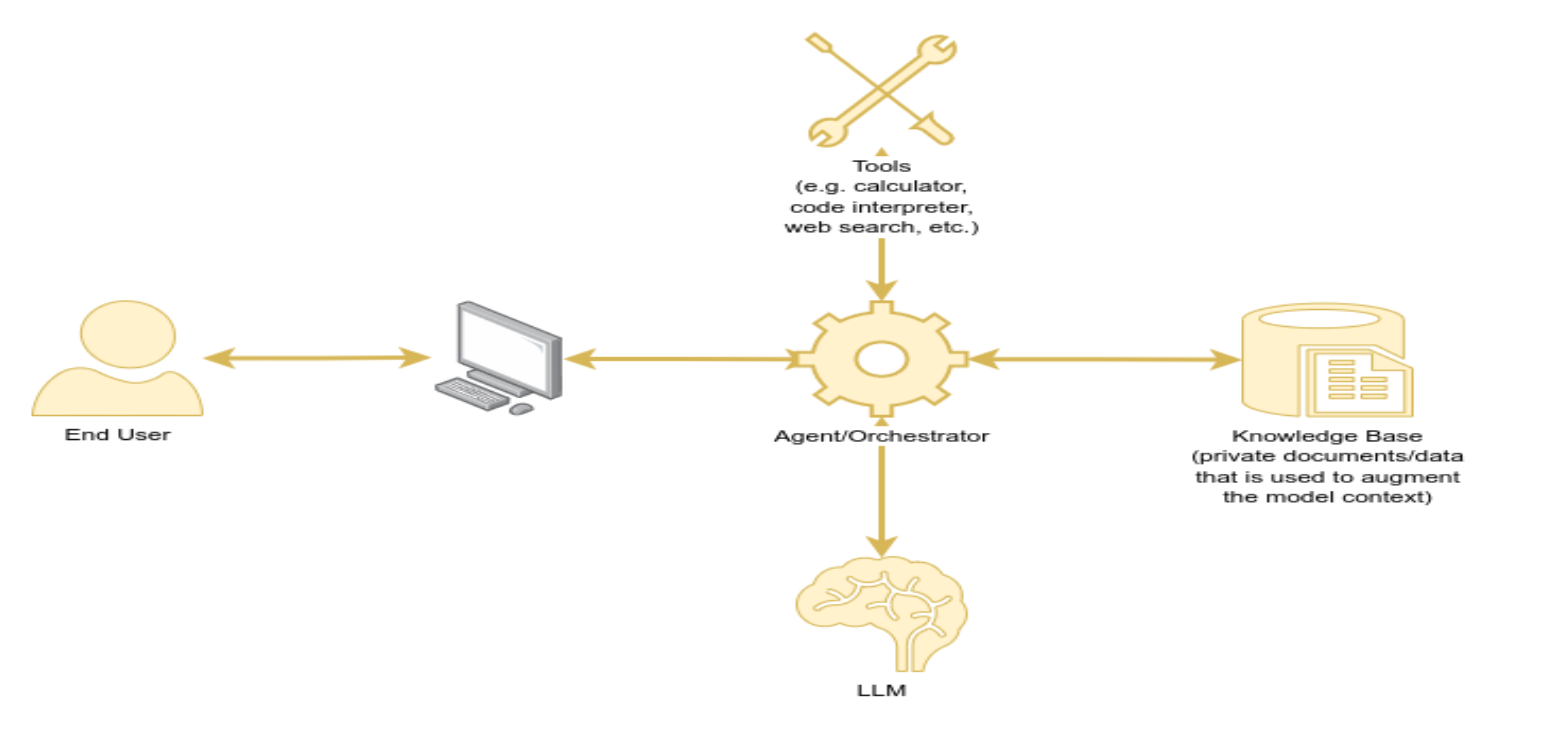

It is pretty much required in most of the actual practical business applications, our AI can either:
- Perform some actions / affect the environment in different ways,
- Utilize the company's private data to process it and provide the users with some information regarding it. 

For chatbot-based applications, one of the most popular use cases is to augment the users workflows by allowing them to ask questions about some internal data easily – in **natural language**.

With RAG, in addition to the (G)eneration step (which we already had), we're also (R)retrieving the relevant information, and (A)ugmenting the content of our model. RAG conceptual flow looks as follows:

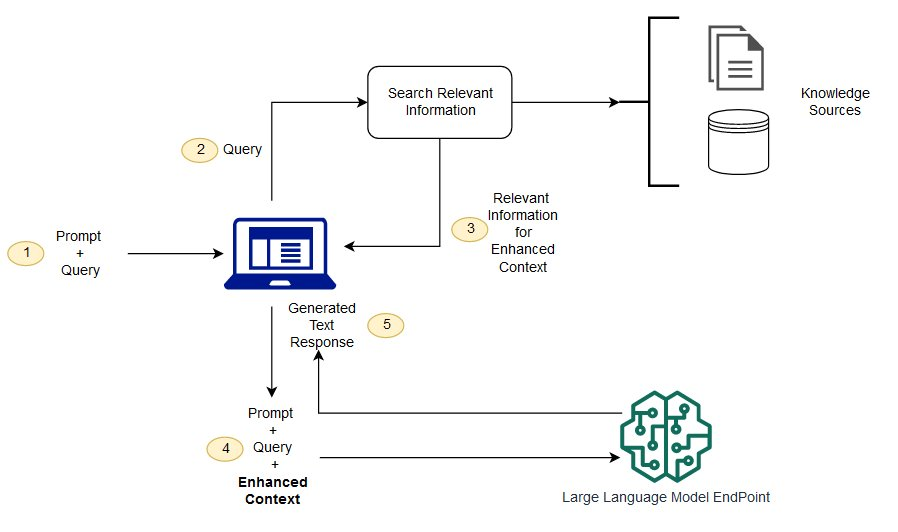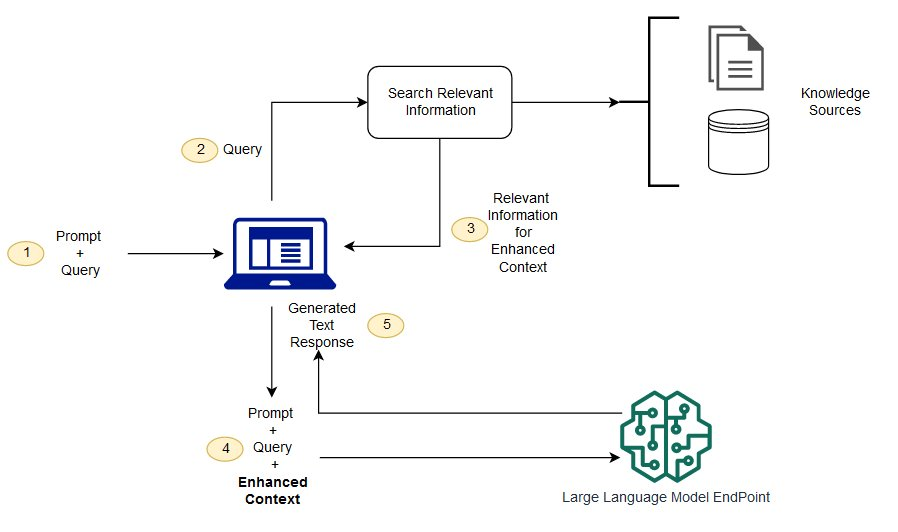

(src: [AWS](https://aws.amazon.com/what-is/retrieval-augmented-generation/))

We now need to implement the retrieval part. Usually, on a high level, it consists of two stages:
- First, we actually load the data, transformed into mathematical representation (**embeddings**) to a **Vector Store**.
- Then, during the actual conversation, we **embdedd** user message/query and retrieve relevant/similar document fragments (**chunks**) and add them into the context (part of the input message) that we send to LLM to generate the answer.

## Initialize vector storage

We will utilize [Chroma](https://www.trychroma.com/) – a popular, open-source vector store solution (but there is also a number of other options, with their different tradeoffs) for storing our internal documents.

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

embeddings = OpenAIEmbeddings(model="text-embedding-3-large", api_key=OPENAI_API_KEY)
CHROMA_DB_PATH = "./chroma_langchain_db"


vector_store = Chroma(
    collection_name="shrek_script_collection", embedding_function=embeddings, persist_directory=CHROMA_DB_PATH
)

In [ ]:
# Hint: this minor utility can help us if something goes wrong and we need to clear the collection – it needs to be done directly 
# through connection to vector store.

from chromadb import PersistentClient


def delete_collection(chroma_path: str, collection_name: str) -> None:
    try:
        chroma_client = PersistentClient(path=chroma_path)
        chroma_client.delete_collection(collection_name)
        print(f"Collection {collection_name} deleted successfully.")
    except Exception as e:
        raise Exception(f"Unable to delete collection: {e}")

## Add documents

We will now load our private data, which will consist of the script for the adventures of this green guy:
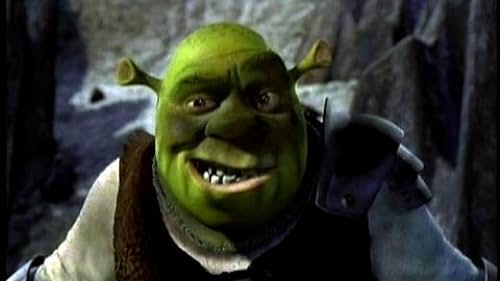


We rarely put the whole document into a single embedding. That way, most of the information would be likely lost. Instead, we usually split them into parts (chunks). Building optimal RAG is actually quite a challenge in practical systems, and choosing a fitting chunk size is one of its hyperparameters. But for one purpose, we will do it in a slightly crude way, and just split document into a set of big chunks that we will put into the DB. Larger chunks results in more text being passed as context. It may improve the accuracy (but might also make it harder to get relevant chunks in a query) of our LLM's answer, but it increases the cost of the processing/API call.

In [ ]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = TextLoader("./docs/shrek_movie_script.txt")
document = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
chunked_documents = text_splitter.split_documents(document)

# clear collection before adding documents
ids = vector_store.get()["ids"]
if len(ids) > 0: vector_store.delete(ids)

vector_store.add_documents(chunked_documents)

## Let's ask away!

In [ ]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

if "rag_session_1" in STORE:
    del STORE["rag_session_1"]

config = {"configurable": {"session_id": "rag_session_1"}}

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """You are a helpful assistant and a literature specialist. Answer all questions to the best of your ability.
        During answering use this context from documents: {context}. If you do not know the answer - do not provide it.
            Answear as short as possible, preferably in one sentence""",
        ),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{input}"),
    ]
)

chain = prompt | llm

rag_chain_with_history = RunnableWithMessageHistory(
    chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
)

retriever = vector_store.as_retriever()
rag_chain_from_docs = (
    {
        "context": retriever | format_docs,
        "input": RunnablePassthrough(),
    }
    | rag_chain_with_history
)

response = rag_chain_from_docs.invoke(
    "What were the names of the princesses that the mirror was talking about?", config=config
)
print(response.content)

The answer should be correct – but it would be nice to actually what resources this answer is based on.

In [ ]:
# a little "hacky" modification that in parallel also runs another chain responsible for storing retriever context
rag_chain_retrieval_top_docs = {"context": retriever} | RunnablePassthrough()

parallel_runnable = RunnableParallel(rag_chain_from_docs=rag_chain_from_docs, rag_chain_retrieval_top_docs=rag_chain_retrieval_top_docs)
response = parallel_runnable.invoke("What were the names of the princesses that the mirror was talking about?", config=config)

print("Response:", response["rag_chain_from_docs"].content)
print("Documents context:", "\n\nAnother chunk\n\n".join([doc.page_content for doc in response["rag_chain_retrieval_top_docs"]["context"]]))

Larger chunks not always give the best results. It is usually application dependent, and one must chunk accordingly to use case (e.g. in our scenario for the answer we would always need a specific paragraph of the document and nothing more – this is what we should split based on).
There are also tradeoff costs – chunks with smaller sizes reduce costs by providing fewer tokens in context.

**Exercise:** Let's experiment a bit – and run experiments for different chunk sizes.
Try to use different chunks sizes and overlaps, possibly even very small.

Hint: Utilize the previous code, don't forget about cleaning/setting up the session and Chroma collections.

Hint: You can try with chunk sizes 1500 and 300 and then 300 and 50 respectively when asking "What were the names of the princesses that the mirror was talking about?"

You can find more about using Chroma with Langchain in [docs](https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/).

If you want to learn more about components used in this section, check out those links:

- [document loaders](https://python.langchain.com/v0.2/docs/how_to/#document-loaders)
- [text splitters](https://python.langchain.com/v0.2/docs/how_to/#text-splitters)
- [embedding models](https://python.langchain.com/v0.2/docs/how_to/#embedding-models)
- [retrievers](https://python.langchain.com/v0.2/docs/how_to/#embedding-models)

# Put it all together – demo with Frontend (inside notebook)

In [ ]:
import panel as pn

pn.extension()


async def callback(contents: str, user: str, instance: pn.chat.ChatInterface):
    message = ""
    for response in rag_chain_from_docs.stream(contents, config=config):
        message += response.content
        yield message


config = {"configurable": {"session_id": "rag_session_5"}}
chat_interface = pn.chat.ChatInterface(callback=callback, callback_user="Shrek director")
chat_interface.servable()

With all that we're set – we have our own chatbot implemented in Python code, covering important underneath mechanisms! 

🎉 Congratulations! 🎉

But, there is still more that you could do...

**Exercise:** Did you know, that Shrek is actually based on a book? You can found it under **docs/shrek_book.pdf** – modify the previous code and RAG implementation to be able to use our chat interface to ask questions about the original green ogre...

Or, you can plug in some of your resources (maybe in combination with UI which can be found further) – if you have some ideas, go for it.

**Hint:** similarly to TextLoader, Langchain has utilities that help with PDF documents.

**Exercise:** In the repository, there is a simple Chat UI called **app.py** – it has less capabilities on the backend side then we did in the notebook and no RAG – connect some more batteries, including vector store and retrieval to it.

In [ ]:
# This one is open ended – whatever people will find interesting, they may do with that.

**Exercise:** So far, we've only utilized 3rd party LLMs. Hosting one by oneself is very hardware heavy – but possible, for smaller models.

**Hint:** It may take time to download the model and even though we selected a very small one, demanding to run it (generations may be slow). You may want to start installing dependencies and downloading the model.

**Hint:** This model performance might be subpar compared to commercial ones with hundreds of times more params – but do not be surprised about the model getting something wrong.

In [ ]:
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline
from huggingface_hub import login

HF_TOKEN = os.environ["HUGGINGFACEHUB_API_TOKEN"]

login(token=HF_TOKEN)

llm = HuggingFacePipeline(
    # TODO
)

response = rag_chain.invoke("Who was Shrek's partner when rescuing Fiona?", config=config)
print(response.content)

If you are interested, check more information about integrating with Hugging Face:

- [Integrating with Hugging Face using Langchain](https://python.langchain.com/v0.1/docs/integrations/platforms/huggingface/)
- [Hugging Face docs](https://huggingface.co/docs)